In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import random as random


trainset_1 = pd.read_csv('EEG_mouse_data_1.csv')
trainset_2 = pd.read_csv('EEG_mouse_data_2.csv')
testset_1 = pd.read_csv('EEG_mouse_data_test.csv')

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return true;
}

In [7]:
# visualisation des données par classe
def show_boxplots(df):
    fig, axs = plt.subplots(20, 5, figsize=(25, 120))
    axs = axs.flatten()

    for i, col in enumerate(df.columns[1:]):
        sns.boxplot(x='state', y=col, data=df, ax=axs[i])
    
    fig.suptitle('Boxplot of the amplitudes', fontsize=14)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])


In [8]:
# normlisation des features
from sklearn.preprocessing import StandardScaler
import pandas as pd

def normalize(df):
    headers = df.columns
    scaler = StandardScaler()
    
    numerical_columns = df.select_dtypes(include=['int', 'float']).columns
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    normalized_data = pd.DataFrame(df, columns=headers[:-1])

    return normalized_data

In [9]:
# extraction des colonnes
# envisager de faire la séléction des features ici
def extract_features(data, n):
    return data.iloc[:,:n+1]


In [153]:
def create_model():
  # 2 inputs
  # 2 hidden nodes
  # 1 output

  mlp = keras.Sequential([
      layers.Input(shape=(25,)),
      layers.Dense(3, activation="tanh"), # Try different numbers of hidden neurons here (e.g. 2, 4, 8, 32, 128)
      layers.Dense(1, activation="tanh"),
  ])

  # Experiment with hyperparameters here:
  # momentum: [0, 0.8, 0.9, 0.99]
  # learning_rate: [0.1, 0.01, 0.001, 0.0001]
  mlp.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.99),
      loss="mse",
  )

  return mlp
mlp = create_model()
mlp.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape              ┃        Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                  │ (None, 3)                 │             78 │
├───────────────────────────────────┼───────────────────────────┼────────────────┤
│ dense_23 (Dense)                  │ (None, 1)                 │              4 │
└───────────────────────────────────┴───────────────────────────┴────────────────┘

 Total params: 82 (328.00 B)

 Trainable params: 82 (328.00 B)

 Non-trainable params: 0 (0.00 B)

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import random as random
# Programme principal de traitement du train set #1
normal_trainset_1 = extract_features(trainset_1, 26)
normal_trainset_1 = normalize(normal_trainset_1)
normal_trainset_1 = normal_trainset_1.sample(frac=1, random_state=42)

# splitting en 3 folds
keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

y = normal_trainset_1['state'].map({'w': 1, 'r': 0, 'n': 0})
normal_trainset_1.drop(columns=['state'], inplace=True)
history_list = []
trained_mlp = []
for fold, (train_index, test_index) in enumerate(kf.split(normal_trainset_1)):
    
    model = create_model()
    
    history = model.fit(x=normal_trainset_1.iloc[train_index], y=y.iloc[train_index], 
                       validation_data=(normal_trainset_1.iloc[test_index], y.iloc[test_index]),
                       epochs=100)
    
    history_list.append(history)
    trained_mlp.append(model)

Epoch 1/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2346 - val_loss: 0.0988
Epoch 2/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0966 - val_loss: 0.0807
Epoch 3/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0833 - val_loss: 0.0770
Epoch 4/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0811 - val_loss: 0.0752
Epoch 5/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0790 - val_loss: 0.0735
Epoch 6/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0781 - val_loss: 0.0731
Epoch 7/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0780 - val_loss: 0.0729
Epoch 8/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0778 - val_loss: 0.0726
Epoch 9/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0782 - val_loss: 0.0722
Epoch 10/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0781 - val_loss: 0.0760
Epoch 11/100


KeyboardInterrupt: 

C:\Users\Julien\miniconda3\envs\ARN\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Julien\miniconda3\envs\ARN\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Julien\miniconda3\envs\ARN\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Julien\miniconda3\envs\ARN\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Julien\miniconda3\envs\ARN\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: object of type 'numpy.float64' has no len()

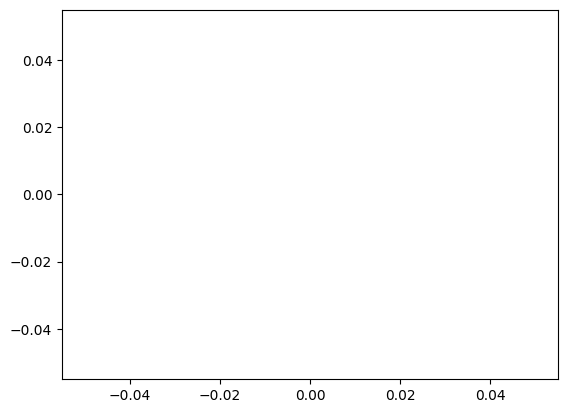

In [155]:
import numpy as np
import matplotlib.pyplot as pl
train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

In [156]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    pl.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["r/nr", "w"], yticklabels=["r/nr", "w"])
    pl.title(title)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

f1_scores = []
mean_confusion_matrix = np.zeros((2, 2))

for i, (train_index, test_index) in enumerate(kf.split(normal_trainset_1)):
    # Evaluate the trained model on the test fold
    predictions = (trained_mlp[i].predict(normal_trainset_1.iloc[test_index]) > 0).astype(int)
    true_labels = (y.iloc[test_index] > 0).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    mean_confusion_matrix += confusion_matrix(true_labels, predictions)

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')

    # Compute F1 score
    f1 = f1_score(true_labels, predictions)
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")

IndexError: list index out of range

# Entrainement du modèle avec 3 classes

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold

def create_model_three_class():
  # 2 inputs
  # 2 hidden nodes
  # 1 output

  mlp = keras.Sequential([
      layers.Input(shape=(25,)),
      layers.Dense(5, activation="tanh"), # Try different numbers of hidden neurons here (e.g. 2, 4, 8, 32, 128)
      layers.Dense(3, activation="tanh"),
  ])

  # Experiment with hyperparameters here:
  # momentum: [0, 0.8, 0.9, 0.99]
  # learning_rate: [0.1, 0.01, 0.001, 0.0001]
  mlp.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.99),
      loss="mse",
  )

  return mlp
mlp = create_model_three_class()
mlp.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape              ┃        Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                  │ (None, 5)                 │            130 │
├───────────────────────────────────┼───────────────────────────┼────────────────┤
│ dense_35 (Dense)                  │ (None, 3)                 │             18 │
└───────────────────────────────────┴───────────────────────────┴────────────────┘

 Total params: 148 (592.00 B)

 Trainable params: 148 (592.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 3 classes

import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import random as random

# Programme principal de traitement du train set #1
normal_trainset_1_three_class = extract_features(trainset_1, 26)
normal_trainset_1_three_class = normalize(normal_trainset_1_three_class)
normal_trainset_1_three_class = normal_trainset_1_three_class.sample(frac=1, random_state=42)

# splitting en 3 folds
keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

y = normal_trainset_1_three_class['state'].map({'w': 2, 'r': 1, 'n': 0})
normal_trainset_1_three_class.drop(columns=['state'], inplace=True)

history_list_three_class = []
trained_mlp_three_class = []
for fold, (train_index, test_index) in enumerate(kf.split(normal_trainset_1_three_class)):
    
    model = create_model_three_class()
    
    history = model.fit(x=normal_trainset_1_three_class.iloc[train_index], y=y.iloc[train_index], 
                       validation_data=(normal_trainset_1_three_class.iloc[test_index], y.iloc[test_index]),
                       epochs=300)
    
    history_list_three_class.append(history)
    trained_mlp_three_class.append(model)

Epoch 1/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9515 - val_loss: 0.7065
Epoch 2/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.6826 - val_loss: 0.7057
Epoch 3/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 0.6797 - val_loss: 0.7049
Epoch 4/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6779 - val_loss: 0.7043
Epoch 5/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6764 - val_loss: 0.7041
Epoch 6/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6751 - val_loss: 0.7042
Epoch 7/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6744 - val_loss: 0.7037
Epoch 8/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6739 - val_loss: 0.7040
Epoch 9/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.6736 - val_loss: 0.7039
Epoch 10/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.6731 - val_loss: 0.7042
Epoch 11/300
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6727 - val_loss: 0.7041
Epoch 12/300
423/423 ━━━━━━━━━━━━

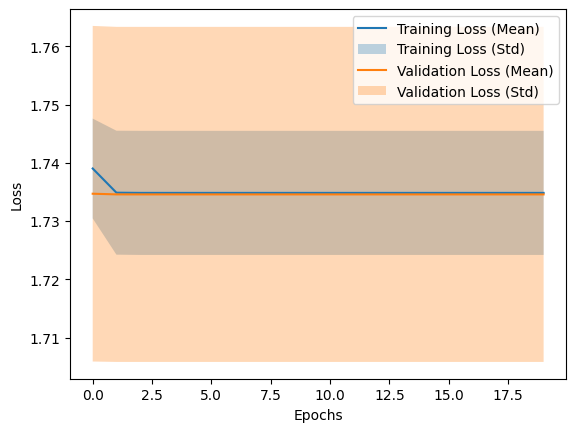

In [159]:
# classes

import numpy as np
import matplotlib.pyplot as pl
train_losses = np.array([history.history['loss'] for history in history_list_three_class])
val_losses = np.array([history.history['val_loss'] for history in history_list_three_class])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
F1 Score - Fold 1: 0.44335850733007554
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
F1 Score - Fold 2: 0.3174885236191322
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
F1 Score - Fold 3: 0.2126777251184834


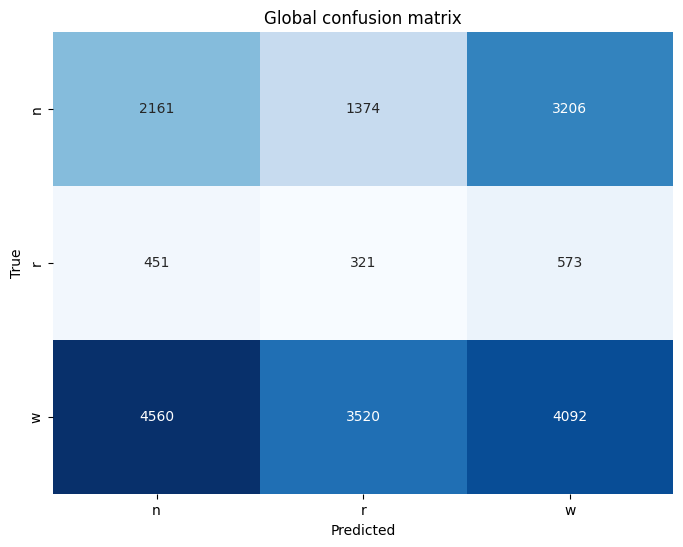

Mean F1 Score across all folds: 0.32450825202256367


In [160]:
# 3 classes

import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    pl.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["n", "r", "w"], yticklabels=["n", "r", "w"])
    pl.title(title)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

f1_scores = []
mean_confusion_matrix = np.zeros((3, 3))

for i, (train_index, test_index) in enumerate(kf.split(normal_trainset_1_three_class)):
    # Evaluate the trained model on the test fold
    predicted_probabilities = trained_mlp_three_class[i].predict(normal_trainset_1_three_class.iloc[test_index])
    predictions = np.argmax(predicted_probabilities, axis=1)
    true_labels = y.iloc[test_index]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    mean_confusion_matrix += confusion_matrix(true_labels, predictions)

    # Compute confusion matrix and plot
    #plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')

    # Compute F1 score
    f1 = f1_score(true_labels, predictions, average='micro')
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")